In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sc
import scipy
from scipy import io

import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [16]:
data_ch1 = scipy.io.loadmat('../data_mat/ECoG_ch1.mat')['ECoGData_ch1'][0]
time = scipy.io.loadmat('../data_mat/ECoG_time.mat')['ECoGTime'][0]
print(data_ch1.shape, time.shape)
data_ch1 = data_ch1[:10000]

(993793,) (993793,)


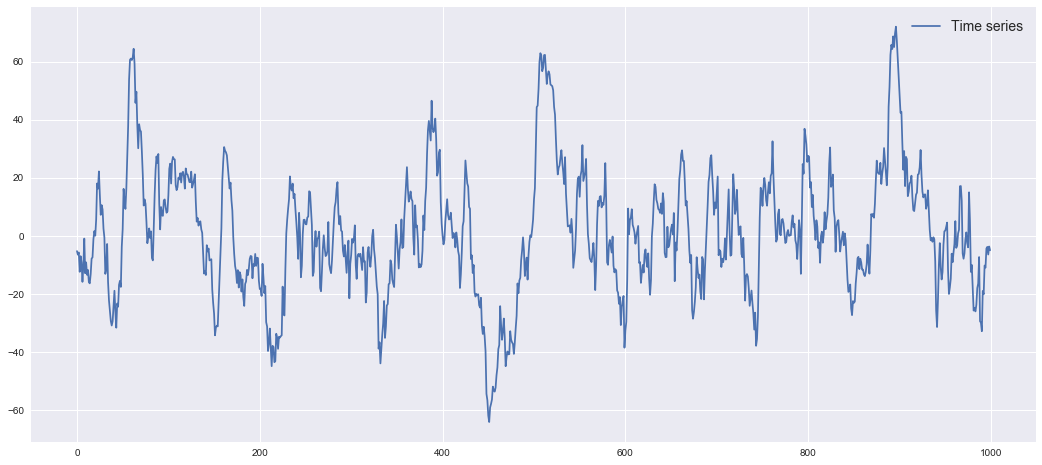

In [18]:
plt.figure(figsize=(18, 8))
plt.plot(data_ch1[::10], label='Time series')
plt.legend(fontsize=14)
plt.show()

In [19]:
n_features = 2500
n_pred = 4
length = len(data_ch1)
n_objects = length - n_features - n_pred
X = np.zeros([n_objects, n_features])
Y = np.zeros([n_objects, n_pred])

for i in range(n_objects):
    X[i, :] = data_ch1[i:i + n_features]
    Y[i, :] = data_ch1[i + n_features: i + n_features + n_pred]

In [7]:
input_X = T.matrix()

def build_nn(n_features, n_hidden=20):
    net = {}
    net['l_input'] = InputLayer(shape=(None, n_features), input_var=input_X)
    net['l_hidden'] = DenseLayer(net['l_input'], num_units=n_hidden)
    net['l_out'] = DenseLayer(net['l_hidden'], num_units=n_features)
    return net

In [8]:
def iterate_minibatches(inputs, batchsize, shuffle=False):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [9]:
n_epochs = 20
batchsize = 16
n_hiddens = [60, 40]
Z = X.copy()
for ae in range(len(n_hiddens)):
    net = build_nn(Z.shape[1], n_hiddens[ae])
    weights = get_all_params(net['l_out'], trainable=True)
    recovered_X = get_output(net['l_out'])
    z = get_output(net['l_hidden'])
    loss = T.mean(lasagne.objectives.squared_error(input_X, recovered_X))
    updates = lasagne.updates.adam(loss, weights, learning_rate=0.00001)
    train = theano.function([input_X], loss, updates=updates)
    representation = theano.function([input_X], z)
    
    loss_array = []
    for epoch in range(n_epochs):
        k = 0
        loss_array.append(0)
        for batch in iterate_minibatches(Z, batchsize):
            loss_array[-1] += train(batch)
            k += 1
        loss_array[-1] /= k
        print("Autoencoder: {:d}, epoch: {:d}, loss: {:.3f}".format(ae+1, 
                                                                   epoch+1, loss_array[-1]))
    Z = representation(Z)

Autoencoder: 1, epoch: 1, loss: 492.795
Autoencoder: 1, epoch: 2, loss: 475.941
Autoencoder: 1, epoch: 3, loss: 461.565
Autoencoder: 1, epoch: 4, loss: 447.413
Autoencoder: 1, epoch: 5, loss: 433.224
Autoencoder: 1, epoch: 6, loss: 419.739
Autoencoder: 1, epoch: 7, loss: 407.470
Autoencoder: 1, epoch: 8, loss: 396.658
Autoencoder: 1, epoch: 9, loss: 387.319
Autoencoder: 1, epoch: 10, loss: 379.318
Autoencoder: 1, epoch: 11, loss: 372.425
Autoencoder: 1, epoch: 12, loss: 366.402
Autoencoder: 1, epoch: 13, loss: 361.101
Autoencoder: 1, epoch: 14, loss: 356.341
Autoencoder: 1, epoch: 15, loss: 351.947
Autoencoder: 1, epoch: 16, loss: 347.792
Autoencoder: 1, epoch: 17, loss: 343.926
Autoencoder: 1, epoch: 18, loss: 340.385
Autoencoder: 1, epoch: 19, loss: 337.101
Autoencoder: 1, epoch: 20, loss: 334.026
Autoencoder: 2, epoch: 1, loss: 2071.581
Autoencoder: 2, epoch: 2, loss: 2012.218
Autoencoder: 2, epoch: 3, loss: 1955.031
Autoencoder: 2, epoch: 4, loss: 1899.423
Autoencoder: 2, epoch: 5,

In [21]:
X_train, X_test = X[:2450, :], X[2450:, :]
Y_train, Y_test = Y[:2450, :], Y[2450:, :]

In [20]:
X.shape

(7496, 2500)

In [ ]:
def corr(Y_test, Y_pred):
    
    

In [111]:
n_array = np.arange(2, 20)

best_mse = np.inf

for n in n_array:
    pls = PLSRegression(n_components=n, scale=False)
    pls.fit(X_train, Y_train)
    Y_pred = pls.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
#     corr = np.correlate(Y_test[0], Y_pred[0])
#     maperes = mape(Y_test, Y_pred)
    corr = np.corrcoef(Y_test[0], Y_pred[0]).mean()
    smse = tss_func(Y_test)/rss_func(Y_test, Y_pred)
    if mse < best_mse:
        best_n = n
        best_mse = mse
    print(n, mse, corr)    
best_n, best_mse

2 606.077667818 0.201863949089
3 559.083190531 0.197839950131
4 529.994855244 0.196810064008
5 529.618169434 0.192047039138
6 537.71291576 0.189566201592
7 523.776876083 0.190535463563
8 531.043805614 0.186598283991
9 551.631385965 0.192902634945
10 547.037125923 0.191541690464
11 578.998665137 0.195374987907
12 593.678250381 0.20100629376
13 625.447366492 0.199902249913
14 663.790591822 0.201683029979
15 706.569751106 0.205726919318
16 781.604400839 0.198331771309
17 823.144247183 0.205594142955
18 890.887063401 0.209261324607
19 935.018444347 0.209939463175


(7, 523.77687608327949)

In [24]:
pls = PLSRegression(n_components=best_n, scale=False)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)
W = pls.x_weights_
Coef = pls.coef_

In [105]:
def mape(Y_test, Y_pred, vector=False):
    n = Y_test.shape[0]
    m = Y_test.shape[1]
    if vector==False:
        res = np.sum(np.divide(np.abs(Y_test - Y_pred), np.abs(Y_test))) * 100. / n / m
    else:
        res = np.sum(np.divide(np.abs(Y_test - Y_pred), np.abs(Y_test)), 0) * 100 / n  
    return res

In [52]:
print(mean_squared_error(Y_test, Y_pred))
print(mean_absolute_error(Y_test, Y_pred))
print(mape(Y_test, Y_pred))

17.0469048195
3.46541323135
89.7287606856


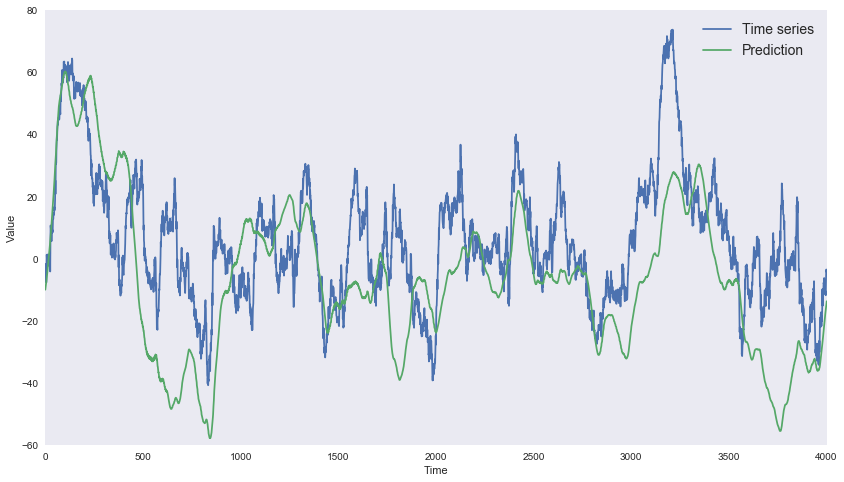

In [92]:
ts_test = Y_test.ravel()
ts_pred = Y_pred.ravel()
ts = ts_test*0

plt.figure(figsize=(14, 8))
plt.plot(ts_test[::5], label='Time series')
plt.plot(ts_pred[::5], label='Prediction')
plt.legend(fontsize=14)
plt.axis([0, 4000, -60, 80])
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid()
plt.savefig('destination_path.eps', format='eps', dpi=1000, transparent=True)
plt.show()

In [76]:
def sumsqr(x, y):
    return mean_squared_error(x, y) * x.shape[0]

In [77]:
def rss_func(Y_test, Y_pred):
    return sumsqr(Y_test, Y_pred)

In [98]:
def tss_func(Y_test):
    Y_mean = np.ones(Y_test.shape)
    for i in range(Y_mean.shape[1]):
        Y_mean[:, i] = np.mean(Y_test, 0)[i]
    return sumsqr(Y_test, Y_mean)

In [78]:
def cp(X, w, y, rss):
    p = np.size(w) / w.shape[0]
    m = X.shape[0]
    return sumsqr(y, np.dot(X, w)) / rss - m + 2 * p

In [79]:
def my_collintest(X, eps=10e-4):
    '''
    Function computes matrix of the coefficient variance proportion according 
    to the Belsley approach to the multicollinear features detection. 

    Input:
    X - [m, n] - design matrix

    Output:
    VarDecomp - [n, n] - matrix of the coefficients variance proportion
    ''' 
    numObs, numVars = X.shape
    
    # Scale columns to length 1:
    colNormsX = np.sqrt(np.sum(np.square(X), 0))
    colNormsX[colNormsX == 0] = 1 # Avoid divide by 0
    XS = np.divide(X, np.matlib.repmat(colNormsX, numObs, 1))  # Scaled X

    # Compute SVD:
    _, sValue, V = np.linalg.svd(XS, full_matrices=False)

    # Compute condition indices:
    sValue[sValue < eps] = eps # Avoid divide by 0

    # Compute variance decomposition proportions:
    PHI = np.divide(np.square(V), np.matlib.repmat(np.square(sValue).transpose(), numVars,1)) 
    phi = np.sum(PHI, 1)
    VarDecomp = np.divide(PHI.transpose(), np.matlib.repmat(phi.transpose(), numVars, 1))
    return VarDecomp

In [80]:
def AlgBelsley(X, idxFeatures):
    '''
    Find index the worst feature, the most collinear, through the Belsley
    diagnosis
    [ intIdxDelFeature ] = algBelsley(X, idxFeatures)

    Input:
    X - [m, p] - full design matrix
    idxFeatures - [1, k] - vector containing indices of currently used features

    Output:
    intIdxDelFeature - [1, 1] - index of the deleted feature from idxFeature
                                vector
    '''
    VarDecomp = my_collintest(X[:, idxFeatures])
    idxMaxVarProp = np.argmax(VarDecomp[-1, :])
    intIdxDelFeature = idxFeatures[idxMaxVarProp]
    return intIdxDelFeature

In [81]:
def stability(X, y, w, s_0, X_unnorm):
    '''
    Function computes the number of features, 
    after their deleting the error function is less than par.s_0. 
    Deleting features is implemented through the Belsley procedure.     
     
    Input:
    X - [m, p] - design matrix with shrinkage number of predictors
    y - [m, 1] - target vector
    w - [p, 1] - vector of parameters, getting from algorithm, 
               which is tested
    s_0 - [1, 1] - limit acccepted error rate
    X_unnorm - [m, p] - design matrix with shrinkage number of predictors
                        but not normalized, because of the 
                        Belsley diagnostic implementation
    
    Output:
    d - [1,1] - maximum number of possibly deleting features
    '''
    idx_all_features = np.arange(w.shape[0])
    d = 0
    S = sumsqr(y, np.dot(X, w))
    while (S < s_0) & (idx_all_features.shape[0] > 1):
        idx_del = algBelsley(X_unnorm, idx_all_features)
        # хз мб надо исправить !!!!
        idx_all_features = idx_all_features.remove(idx_all_features[idx_all_features == idx_del])
        d = d + 1   
        S = sumsqr(y, np.dot(X[:, idx_all_features], w[idx_all_features]))
    return d



In [82]:
W = pls.x_weights_
coef = pls.coef_
x_rotations = pls.x_rotations_
y_rotations = pls.y_rotations_
x_scores = pls.x_scores_ 

In [84]:
def mape(Y_test, Y_pred, vector=False):
    n = Y_test.shape[0]
    m = Y_test.shape[1]
    if vector==False:
        res = np.sum(np.divide(np.abs(Y_test - Y_pred), Y_test)) * 100 / n / m
    else:
        res = np.sum(np.divide(np.abs(Y_test - Y_pred), Y_test), 0) * 100 / n  
    return res

In [85]:
print(mean_squared_error(Y_test, Y_pred))
print(mean_absolute_error(Y_test, Y_pred))
print(mape(Y_test, Y_pred))

523.776876083
17.9395296033
inf


In [86]:
numObs, numVars = x_rotations.shape
colNormsX = np.sqrt(np.sum(np.square(x_rotations), 0))
colNormsX[colNormsX == 0] = 1 # Avoid divide by 0
XS = np.divide(x_rotations, np.matlib.repmat(colNormsX, numObs, 1))  # Scaled X

s_0 = 0.5

stability(w=coef[:, 0], X_unnorm=x_rotations.transpose(), y=y_rotations[0, :], s_0=s_0, X=XS.transpose())

0